In [1]:
import torch as t
from torch import nn
import numpy as np
from tqdm.notebook import tqdm
# import torchopt
import functorch
from functools import partial
from torch.utils.data import DataLoader, Dataset, RandomSampler
from jaxtyping import Float, Int
from typing import Tuple, List, Dict, Any


import os, sys
# HOME = os.environ['HOME']  # change if necessary
HOME = '/workspace/wilson'
sys.path.append(f'{HOME}/Finite-groups/src')
from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from model_utils import *
from train import Parameters
from functools import partial, reduce
%load_ext autoreload
%autoreload 2

**Idea**: "Fantastic generalization measures and where to find them" does early stopping by training loss. (Otherwise, training loss would be predictive of generalization.) If we do the same, would we still observe grokking at all? Try on intersection of S4 and A4x2

In [2]:
losses = load_loss_trajectory('/workspace/wilson/Finite-groups/models/2025-01-08_03-15-59_S4_A4x2_MLP2_32_ubias_wd2e-4_BIG_hmmmetrics')

/workspace/wilson/Finite-groups/src/utils.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  losses = [t.load(f) for f in loss_files]


In [3]:
losses.keys()

dict_keys(['G0_loss', 'G0_acc', 'G1_loss', 'G1_acc', 'epoch_train_loss', 'epoch_train_acc', 'epoch_train_margin'])

In [4]:
losses['G0_loss'].shape

torch.Size([10000, 2169])

In [42]:
ACC_THRESH = 0.95
print('G0 grokked', (losses['G0_acc'][:,-1] > ACC_THRESH).sum())
print('G1 grokked', (losses['G1_acc'][:,-1] > ACC_THRESH).sum())

G0 grokked tensor(670, device='cuda:0')
G1 grokked tensor(42, device='cuda:0')


Text(0.5, 1.0, 'Final train loss per instance')

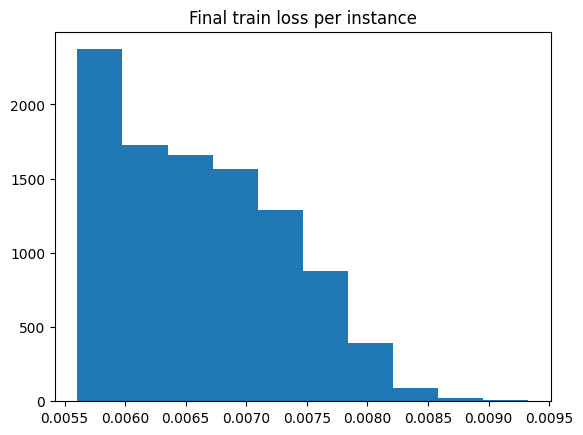

In [43]:
plt.hist(losses['epoch_train_loss'][:,-1].detach().cpu().numpy())
plt.title('Final train loss per instance')

In [44]:
early_stop_thresh = 0.007
early_G0_accs = []
early_G1_accs = []
stop_idxs = []
for inst in range(losses['epoch_train_loss'].shape[0]):
    try:
        stop_idx = (losses['epoch_train_loss'][inst,1:] < early_stop_thresh).nonzero()[0].item()
    except IndexError:
        continue
    stop_idxs.append(stop_idx)
    early_G0_accs.append(losses['G0_acc'][inst, stop_idx].item())
    early_G1_accs.append(losses['G1_acc'][inst, stop_idx].item())

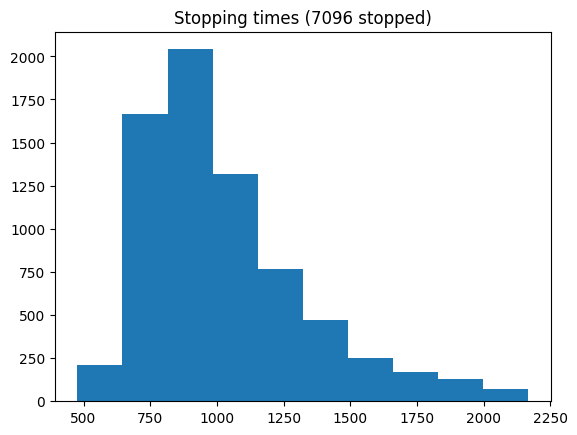

In [45]:
plt.hist(stop_idxs)
plt.title(f'Stopping times ({len(stop_idxs)} stopped)')
plt.show()

In [46]:
print('G0 early stop grokked', (np.array(early_G0_accs) > ACC_THRESH).sum())
print('G1 early stop grokked', (np.array(early_G1_accs) > ACC_THRESH).sum())

G0 early stop grokked 11
G1 early stop grokked 3


In [ ]:
losses['epoch_train_loss'][0]

tensor([0.0000, 3.2051, 3.1497,  ..., 0.0058, 0.0058, 0.0058], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [20]:
(losses['epoch_train_loss'][0,:5] > 100).nonzero()[0]

IndexError: index 0 is out of bounds for dimension 0 with size 0